### Configuration and libraries

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt


import os
from ament_index_python.packages import get_package_share_directory
import yaml
from matplotlib import cm  # for a scatter plot
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'figure.max_open_warning': 0})

# Latex settings
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          "font.size" : 16}
plt.rcParams.update(params)

PACKAGE_NAME = "drone_pose_estimation"
FOLDER_NAME  = 'data'

# the following values can be extracted dynamically, but setting them is easier
TESTED_SETTINGS = ['setting1', 'setting2', 'setting3', 'setting4', 'setting5'] 
N_RUN       = 50
N_DRONES    = 10
N_ITERATION = 30

IN_PROJECT = False

# init the path where the data are stored
package_path = None

# Initialize Viridis colors
colors = cm.viridis(np.linspace(0, 1, 5))

if IN_PROJECT:
    package_path = get_package_share_directory(PACKAGE_NAME)
    data_folder_path = os.path.join(package_path, FOLDER_NAME)
else:
    data_folder_path = FOLDER_NAME

# Export path
PATH = '/home/oselin/Desktop/'

### Load data to structure

In [2]:
data = {}

for setting in TESTED_SETTINGS:
    data[setting] = {
        'runs': []
    }

    for k in range(N_RUN):
        data[setting]['runs'].append({
            'X_storage'     : None,
            'X_mds_storage' : None,
            'X_lsm_storage' : None
        })

        # Define the k-th run folder
        folder_path = os.path.join(data_folder_path, setting, f'run{k+1}')
        
        # Read X_storage file
        try:
            with open(os.path.join(folder_path, 'X_storage.txt'), 'r') as file:
                raw_data = np.loadtxt(file)
                data[setting]['runs'][-1]['X_storage'] = raw_data.reshape(raw_data.shape[0], 3, -1)
                file.close()
        except Exception as e:
            print("Exception when reading X_storage")
            print(e)

        # Read X_mds_storage file
        try:
            with open(os.path.join(folder_path, 'X_mds_storage.txt'), 'r') as file:
                raw_data = np.loadtxt(file)
                data[setting]['runs'][-1]['X_mds_storage'] = raw_data.reshape(
                    raw_data.shape[0], 3, -1)
                file.close()
        except Exception as e:
            print("Exception when reading X_mds_storage")
            print(e)

        # Read X_lsm_storage file
        try:
            with open(os.path.join(folder_path, 'X_lsm_storage.txt'), 'r') as file:
                raw_data = np.loadtxt(file)
                data[setting]['runs'][-1]['X_lsm_storage'] = raw_data.reshape(
                    raw_data.shape[0], 3, -1)
                file.close()
        except Exception as e:
            print("Exception when reading X_lsm_storage")
            print(e)

# debug
# print(data)

### Plot all the results (for a faster comparison)

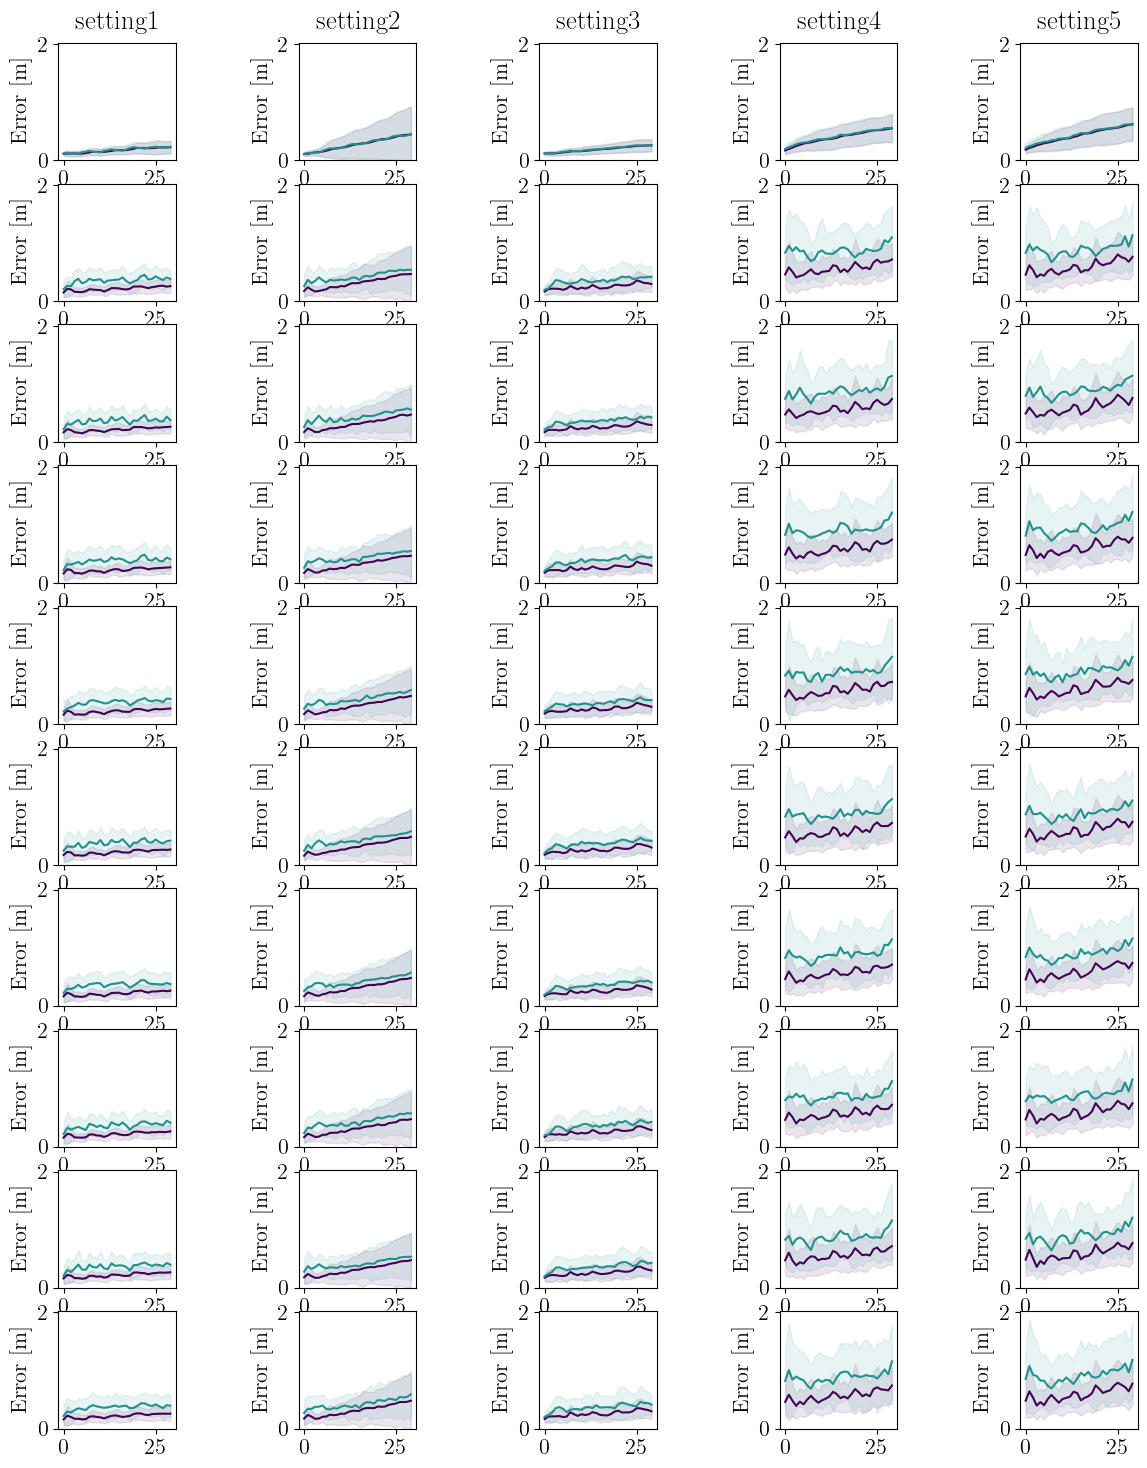

In [3]:
fig, ax = plt.subplots(N_DRONES, len(TESTED_SETTINGS), figsize=(15, 18))

y_max = 0.0

# Pre-allocate memory
sum_mds   = np.zeros((N_DRONES, len(TESTED_SETTINGS)))
count_mds = np.zeros((N_DRONES, len(TESTED_SETTINGS)))

sum_lsm   = np.zeros((N_DRONES, len(TESTED_SETTINGS)))
count_lsm = np.zeros((N_DRONES, len(TESTED_SETTINGS)))

for j, setting in enumerate(TESTED_SETTINGS):

    # Set title only in the first row
    ax[0, j].set_title(setting, y=1.05)
   
    for i in range(N_DRONES):

        mds_errors = np.zeros((N_RUN, N_ITERATION))
        lsm_errors = np.zeros((N_RUN, N_ITERATION))

        for k in range(N_RUN):
            for r in range(N_ITERATION):
                run_data = data[setting]['runs'][k]

                mds_errors[k, r] = np.linalg.norm(
                    run_data['X_mds_storage'][r, :, i] - run_data['X_storage'][r, :, i]
                )

                lsm_errors[k, r] = np.linalg.norm(
                    run_data['X_lsm_storage'][r, :, i] - run_data['X_storage'][r, :, i]
                )

        # Calculate mean and standard deviation
        mds_mean = np.mean(mds_errors, axis=0)
        mds_std  = np.std(mds_errors, axis=0)

        lsm_mean = np.mean(lsm_errors, axis=0)
        lsm_std  = np.std(lsm_errors, axis=0)

        y_max = max(y_max, max(max(mds_mean), max(lsm_mean)) + max(max(mds_std), max(lsm_std)))

        # Configure chart
        # ax[i, j].set_xlabel("Iterations [#]")
        ax[i, j].set_ylabel("Error [m]")

        # Plot MDS performances
        ax[i, j].plot(range(len(mds_mean)), mds_mean, label="MDS", color=colors[0])

        ax[i, j].fill_between(range(len(mds_mean)), mds_mean - mds_std, mds_mean + mds_std, alpha=0.1, color=colors[0])

        # Plot LS performances
        ax[i, j].plot(range(len(lsm_mean)), lsm_mean, label="LSM", color=colors[2])
        ax[i, j].fill_between(range(len(lsm_mean)), lsm_mean - lsm_std, lsm_mean + lsm_std, alpha=0.1, color=colors[2])
        ax[i, j].set_box_aspect(1)

        # Store the data for numerical results
        sum_mds[i, j]   = np.sum(mds_errors)
        count_mds[i, j] = np.prod(mds_errors.shape) 

        sum_lsm[i, j]   = np.sum(lsm_errors)
        count_lsm[i, j] = np.prod(lsm_errors.shape) 
        

for i in range(N_DRONES):
    for j, setting in enumerate(TESTED_SETTINGS):
        ax[i, j].set_ylim(0,y_max)

# fig.legend(
#     loc='upper center',  
#     ncol=1, 
#     fontsize=18,
#     bbox_to_anchor=(0.45, 0.85)
# )
# plt.savefig(path + 'Plot_pso_test_initialization2.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [4]:
print("MDS")
print(np.sum(sum_mds/count_mds, axis=0)/N_DRONES)

print("LSM")
print(np.sum(sum_lsm/count_lsm, axis=0)/N_DRONES)

MDS
[0.21055583 0.31047632 0.24934578 0.5473207  0.57391896]
LSM
[0.34683415 0.41030557 0.34407973 0.83322446 0.85500232]


### Plot single charts

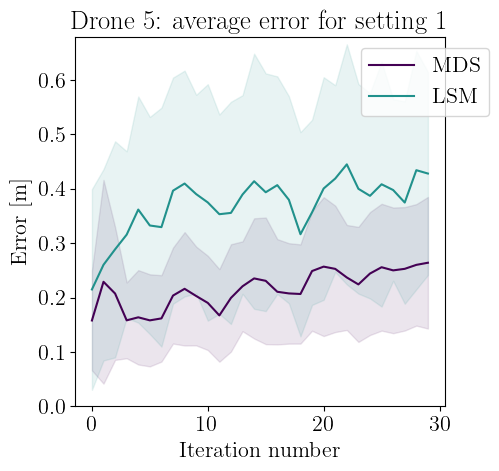

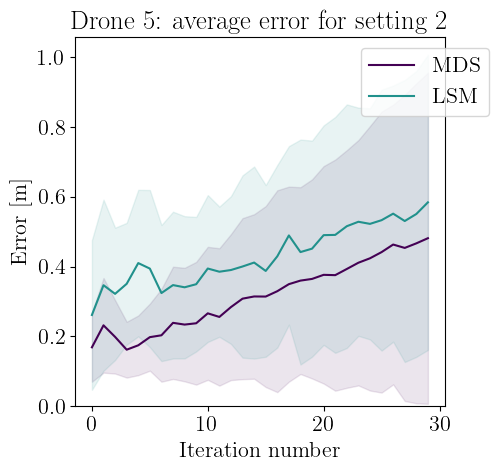

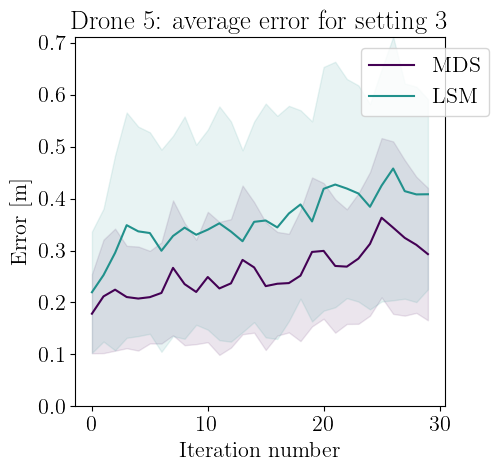

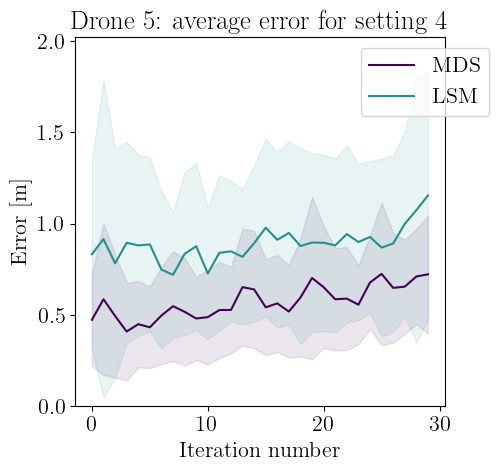

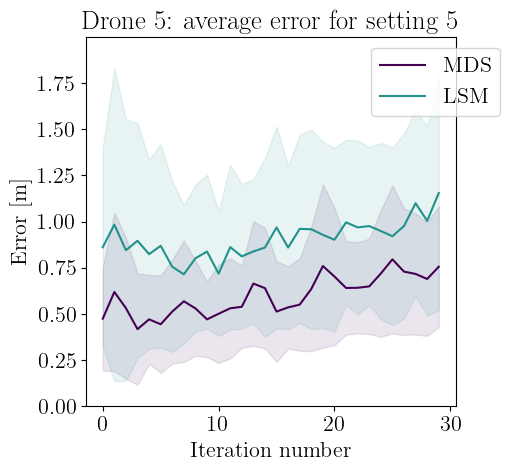

In [5]:
# plot single chart from the previous table specifying the setting and the drone
def plot_single(drone_index, setting):

    # Initialize the figure
    fig_single, ax_single = plt.subplots()

    # Get the drone index
    i = drone_index

    # Pre-allocate memory
    mds_errors = np.zeros((N_RUN, N_ITERATION))
    lsm_errors = np.zeros((N_RUN, N_ITERATION))

    for k in range(N_RUN):
        for r in range(N_ITERATION):
            run_data = data[setting]['runs'][k]

            mds_errors[k, r] = np.linalg.norm(
                run_data['X_mds_storage'][r, :, i] - run_data['X_storage'][r, :, i]
            )
            lsm_errors[k, r] = np.linalg.norm(
                run_data['X_lsm_storage'][r, :, i] - run_data['X_storage'][r, :, i]
            )

    # Calculate mean and standard deviation
    mds_mean = np.mean(mds_errors, axis=0)
    mds_std  = np.std(mds_errors, axis=0)

    lsm_mean = np.mean(lsm_errors, axis=0)
    lsm_std  = np.std(lsm_errors, axis=0)

    y_max = max(max(mds_mean), max(lsm_mean)) + max(max(mds_std), max(lsm_std))

    # Configure chart
    ax_single.set_ylabel("Error [m]")
    ax_single.set_xlabel("Iteration number")
    ax_single.set_ylim(0, y_max)
    
    # Plot MDS performances
    ax_single.plot(range(len(mds_mean)), mds_mean, label="MDS", color=colors[0])
    ax_single.fill_between(range(len(mds_mean)), mds_mean - mds_std, mds_mean + mds_std, alpha=0.1, color=colors[0])

    # Plot LS performances
    ax_single.plot(range(len(lsm_mean)), lsm_mean, label="LSM", color=colors[2])
    ax_single.fill_between(range(len(lsm_mean)), lsm_mean - lsm_std, lsm_mean + lsm_std, alpha=0.1, color=colors[2])
    ax_single.set_box_aspect(1)
    
    plt.legend(loc="upper right", bbox_to_anchor=(1.15,1))
    plt.title(f'Drone {i+1}: average error for setting {setting[-1]}')
    
    # fig_single.legend(loc='upper center', ncol=2)
    plt.savefig(PATH + f'drone{i+1}_{setting}.pdf', dpi=300, format='pdf', bbox_inches='tight')
    plt.show()

plot_single(4, "setting1")
plot_single(4, "setting2")
plot_single(4, "setting3")
plot_single(4, "setting4")
plot_single(4, "setting5")

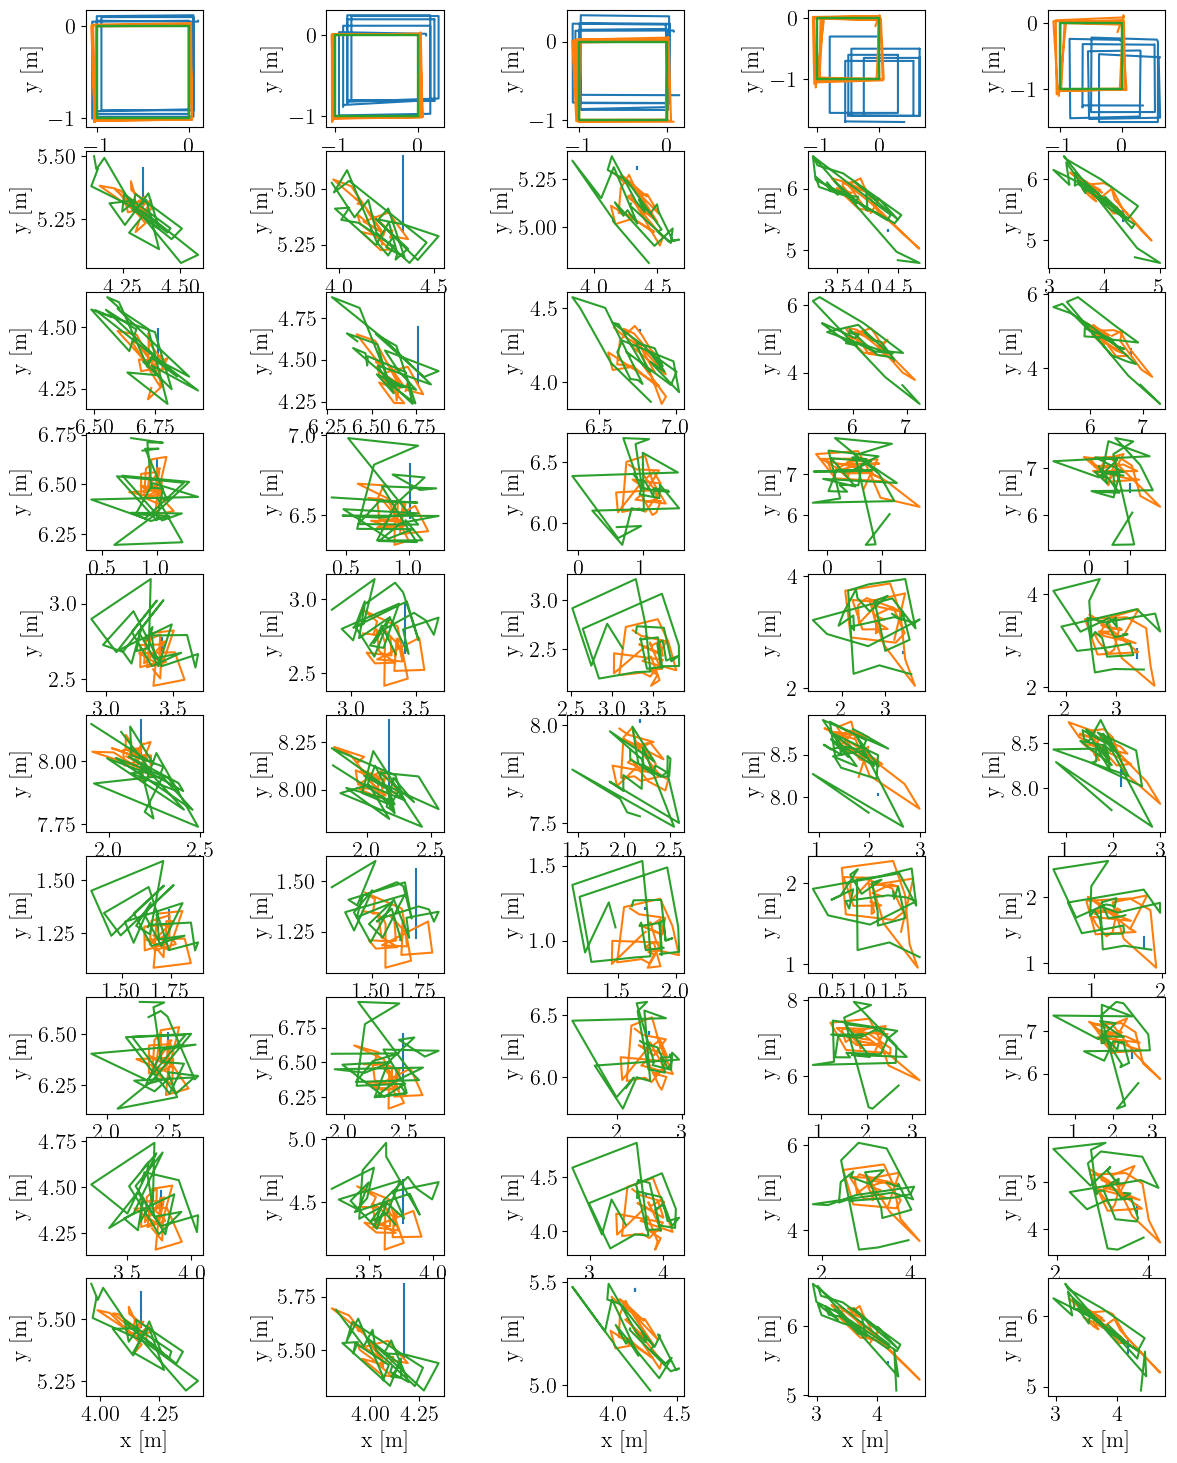

In [6]:
fig_xy, ax_xy = plt.subplots(N_DRONES, len(TESTED_SETTINGS), figsize=(15, 18))

for j, setting in enumerate(TESTED_SETTINGS):
    ax[0, j].set_title(setting, y=1.05)
    # ax[0,0].legend([
    #     'MDS','LSM'
    # ])
    for i in range(N_DRONES):

        k = 0
        r = 0
        # for k in range(N_RUN):
        #     for r in range(N_ITERATION):
        #         run_data = data[setting]['runs'][k]

        #         mds_errors[k, r] = np.linalg.norm(
        #             run_data['X_mds_storage'][r, :, i] - run_data['X_storage'][r, :, i]
        #         )

        #         lsm_errors[k, r] = np.linalg.norm(
        #             run_data['X_lsm_storage'][r, :, i] - run_data['X_storage'][r, :, i]
        #         )
        run_data = data[setting]['runs'][k]

        # Configure chart
        ax_xy[i, j].set_xlabel("x [m]")
        ax_xy[i, j].set_ylabel("y [m]")

        # Plot MDS performances
        ax_xy[i, j].plot(
            run_data['X_storage'][:, 0, i], 
            run_data['X_storage'][:, 1, i], 
            label="X", 
            c='C0'
        )
        ax_xy[i, j].plot(
            run_data['X_mds_storage'][:, 0, i], 
            run_data['X_mds_storage'][:, 1, i], 
            label="MDS", 
            c='C1'
        )
        ax_xy[i, j].plot(
            run_data['X_lsm_storage'][:, 0, i], 
            run_data['X_lsm_storage'][:, 1, i], 
            label="LSM", 
            c='C2'
        )
        
        ax_xy[i, j].set_box_aspect(1)

# fig_xy.legend(
#     loc='upper center',  
#     ncol=1, 
#     fontsize=18,
#     bbox_to_anchor=(0.45, 0.85)
# )
# plt.savefig(path + 'Plot_pso_test_initialization2.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()